# Import Library

In [30]:
! pip install astropy 
! pip install pillow
import cv2
from PIL import Image 
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.interpolate import interp1d
from astropy.convolution import Box2DKernel

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


# Define Variable 

In [31]:
# plt.rcParams["figure.figsize"] = (5,3)

# Define Function

In [32]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def add_gaussian_noise(image, mean=0, std=1):
    """
    Args:
        image : numpy array of image
        mean : pixel mean of image
        standard deviation : pixel standard deviation of image
    Return :
        image : numpy array of image with gaussian noise added
    """
    gaus_noise = np.random.normal(mean, std, image.shape)
    image = image.astype("int16")
    noise_img = image + gaus_noise
    image = ceil_floor_image(image)
    return noise_img 

def ceil_floor_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 with ceilling(maximum 255) and flooring(minimum 0)
    """
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype("uint8")
    return image

def getPixelValueLS(pVal, upperLimit, lowerLimit, imLow, imHigh):
    pNew = ((pVal-imLow)*((upperLimit-lowerLimit)/(imHigh-imLow)))+lowerLimit
    return pNew

def getPixelValueLSClip(pVal, upperLimit, lowerLimit):
    if pVal < lowerLimit:
        return lowerLimit
    elif pVal > upperLimit:
        return upperLimit
    else:
        return pVal

def getPixelValueAVS(pVal, upperLimit, lowerLimit):
#     if valuen is -ve, convert it to +ve
    if pVal < 0:
        if abs(pVal) < lowerLimit:
            return lowerLimit
        else:
            return abs(pVal)
    elif pVal < lowerLimit:
        return lowerLimit
    elif pVal > upperLimit:
        return upperLimit
    else:
        return pVal
    
def getPixelInverse(pVal):
    return 1/pVal

# Main Work

## D.1

##### By using ‘imhist’ ,compute the histogram of the Lena image with 10, 20, 100, and 256 bins. Determine how many pixels are there in the image whose grey scales are 52, 181 and 232?

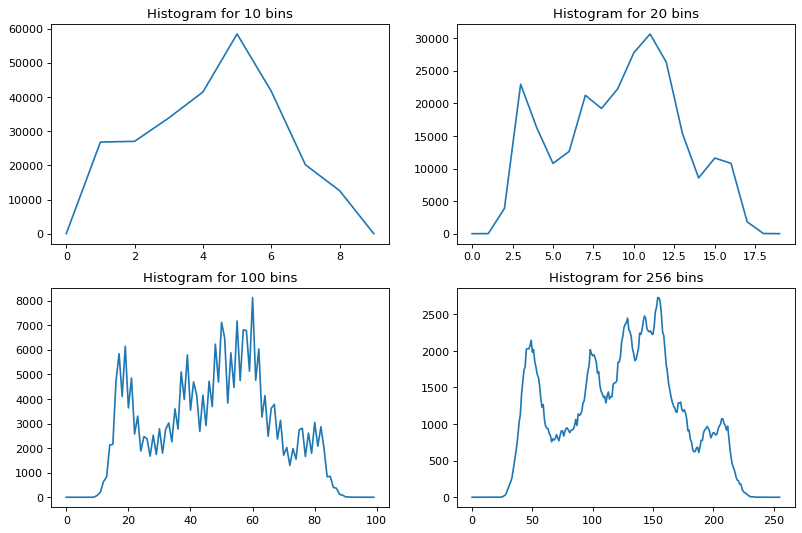

Number of pixels in Grayscale 52: 1852
Number of pixels in Grayscale 181: 794
Number of pixels in Grayscale 232: 6


In [33]:
img_lena = cv2.imread('lenaG.bmp',cv2.IMREAD_GRAYSCALE)
binsSelected = [10, 20, 100, 256]

f = plt.figure(figsize=(12, 8), dpi=80)
for itr, bin_ in enumerate(binsSelected):
    
    # find frequency of pixels in range 0-255
    histr = cv2.calcHist([img_lena],[0],None,[bin_],[0,256])
    f.add_subplot(2,2, itr+1)
    plt.title(f'Histogram for {bin_} bins')
    plt.plot(histr)
plt.show(block=True)

histr = cv2.calcHist([img_lena],[0],None,[256],[0,256])
scalSel = [52, 181, 232]
for scal in scalSel:
    print(f"Number of pixels in Grayscale {scal}: {int(histr[scal])}")

## D.2
##### Scale the histogram so that the grey scales are between 0 and 1 instead of 0 and 255.


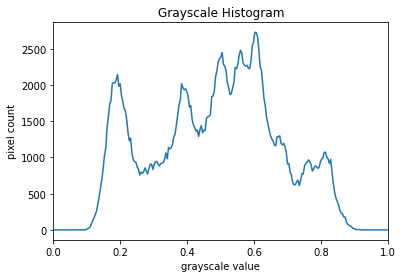

In [34]:
img_lena = cv2.imread('lenaG.bmp',cv2.IMREAD_GRAYSCALE)
# create the histogram
histogram, bin_edges = np.histogram(img_lena/255, bins=256, range=(0, 1))
# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])

plt.plot(bin_edges[0:-1], histogram)
plt.show()

## D.3
##### Scale the histogram, to the area beneath it. Now determine the probability of finding a pixel with grey scales 52, 181 and 232?

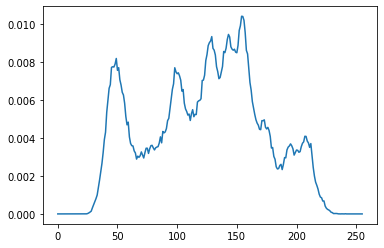

Probability of finding pixel with grayscales 52: [0.00706482]
Probability of finding pixel with grayscales 181: [0.00302887]
Probability of finding pixel with grayscales 232: [2.2888184e-05]


In [35]:
img_lena = cv2.imread('lenaG.bmp',cv2.IMREAD_GRAYSCALE)
histr = cv2.calcHist([img_lena],[0],None,[256],[0,256])
norm_histr = histr / histr.sum()

plt.figure()
plt.plot(norm_histr)
plt.show()
scalSel = [52, 181, 232]
for scal in scalSel:
    print(f"Probability of finding pixel with grayscales {scal}: {norm_histr[scal]}")

## D.4
##### Add some Gaussian noise with standard deviation 20. Find out what the maximum and minimum grey scales of the Lena noisy image are. Are they between 0 and 255? Change the grey scales to be in the interval between 0 and 255 by using the following methods

In [36]:
img_lena = cv2.imread('lenaG.bmp',cv2.IMREAD_GRAYSCALE)
filterSize = img_lena.shape
sigma = 10
gaussFilter = matlab_style_gauss2D(filterSize, sigma)
mean = 0
std_devNoise = 20
img_lenaGaussNoise = add_gaussian_noise(img_lena, mean, std_devNoise)

print(f"Min Value for GrayScale: {np.amin(img_lenaGaussNoise)} \nMax Value for GrayScale: {np.amax(img_lenaGaussNoise)}")

Min Value for GrayScale: -40.58592528156909 
Max Value for GrayScale: 287.3713593412878


##### a) Linear Scaling

In [37]:
upperLimit = 255
lowerLimit = 0
imLow = np.amin(img_lenaGaussNoise)
imHigh = np.amax(img_lenaGaussNoise)
img_lenaLS = np.zeros((int(img_lenaGaussNoise.shape[0]),int(img_lenaGaussNoise.shape[1])))
for posX,imRow in enumerate(img_lenaGaussNoise):
    for posY,pixelValue in enumerate(imRow):
        img_lenaLS[posX, posY] = getPixelValueLS(pixelValue, upperLimit, lowerLimit, imLow, imHigh)

print(f"Min Value for GrayScale: {np.amin(img_lenaLS)} \nMax Value for GrayScale: {np.amax(img_lenaLS)}")

Min Value for GrayScale: 0.0 
Max Value for GrayScale: 255.0


##### b) Linear Scaling with Clipping at 0 and 255

In [38]:
upperLimit = 255
lowerLimit = 0
ctr = 0
img_lenaLSClip = np.zeros((int(img_lenaGaussNoise.shape[0]),int(img_lenaGaussNoise.shape[1])))
for posX,imRow in enumerate(img_lenaGaussNoise):
    for posY,pixelValue in enumerate(imRow):
        img_lenaLSClip[posX, posY] = getPixelValueLSClip(pixelValue, upperLimit, lowerLimit)

print(f"Min Value for GrayScale: {np.amin(img_lenaLSClip)} \nMax Value for GrayScale: {np.amax(img_lenaLSClip)}")

Min Value for GrayScale: 0.0 
Max Value for GrayScale: 255.0


##### c) Absolute Value Scaling

In [39]:
upperLimit = 255
lowerLimit = 0
ctr = 0
img_lenaAVS = np.zeros((int(img_lenaGaussNoise.shape[0]),int(img_lenaGaussNoise.shape[1])))
for posX,imRow in enumerate(img_lenaGaussNoise):
    for posY,pixelValue in enumerate(imRow):
        img_lenaAVS[posX, posY] = getPixelValueAVS(pixelValue, upperLimit, lowerLimit)

print(f"Min Value for GrayScale: {np.amin(img_lenaAVS)} \nMax Value for GrayScale: {np.amax(img_lenaAVS)}")

Min Value for GrayScale: 0.00023105443407445136 
Max Value for GrayScale: 255.0


## D.5
##### Load the “NaturalView.jpg” image and by using the method of linear scaling, stretch the histogram and compare the original image with the stretched histogram one.

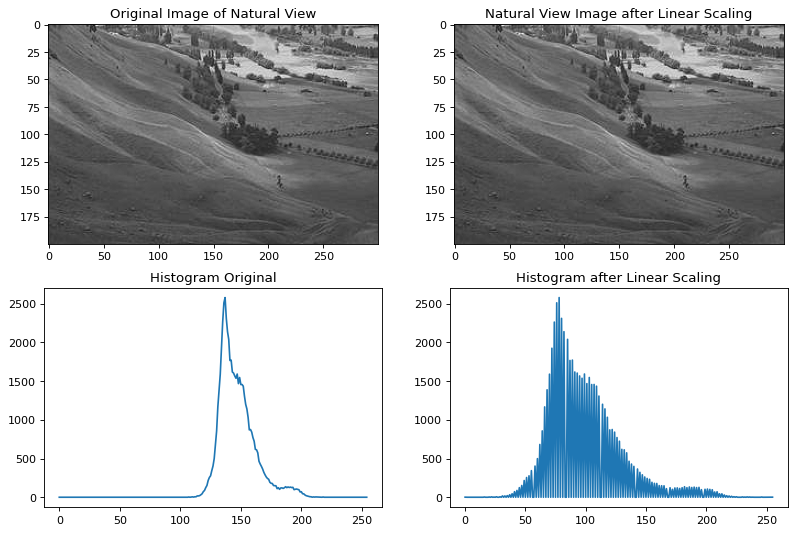

In [40]:
img_NaturalView = cv2.imread('NaturalView.jpeg',cv2.IMREAD_GRAYSCALE)
upperLimit = 255
lowerLimit = 0
imLow = np.amin(img_NaturalView)
imHigh = np.amax(img_NaturalView)
img_NaturalViewLS = np.zeros((int(img_NaturalView.shape[0]),int(img_NaturalView.shape[1])))
for posX,imRow in enumerate(img_NaturalView):
    for posY,pixelValue in enumerate(imRow):
        img_NaturalViewLS[posX, posY] = getPixelValueLS(pixelValue, upperLimit, lowerLimit, imLow, imHigh)
        
f = plt.figure(figsize=(12, 8), dpi=80)
f.add_subplot(2,2, 1)
plt.title('Original Image of Natural View')
plt.imshow(img_NaturalView, cmap='gray')
f.add_subplot(2,2, 2)
plt.title('Natural View Image after Linear Scaling')
plt.imshow(img_NaturalViewLS, cmap='gray')
histr = cv2.calcHist([img_NaturalView],[0],None,[255],[0,256])
f.add_subplot(2,2, 3)
plt.title(f'Histogram Original')
plt.plot(histr)
histogram, bin_edges = np.histogram(img_NaturalViewLS, bins=256, range=(0, 256))
f.add_subplot(2,2, 4)
plt.title(f'Histogram after Linear Scaling')
plt.plot(bin_edges[0:-1], histogram)
plt.show(block=True)

## D.6
##### Transform the Lena image with the power law histogram transformation for p= ½ and 1/3 and 1/5.

TypeError: 'float' object cannot be interpreted as an integer

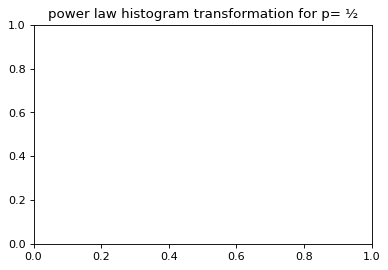

In [46]:
img_Lena = Image.open('lenaG.bmp').convert('LA')

f = plt.figure(figsize=(12, 8), dpi=80)
f.add_subplot(2,2, 1)
plt.title('power law histogram transformation for p= ½')
plt.imshow(img_Lena.point(lambda x: 255*(x//255)**(1/2)), cmap='gray')
f.add_subplot(2,2, 2)
plt.title('power law histogram transformation for p= 1/3')
plt.imshow(img_Lena.point(lambda x: 255*(x//255)**(1/3)), cmap='gray')
f.add_subplot(2,2, 3)
plt.title('power law histogram transformation for p= 1/5')
plt.imshow(img_Lena.point(lambda x: 255*(x//255)**(1/5)), cmap='gray')
plt.show(block=True)

## D.7
##### Calculate the reverse (negative) of the Lena image (255-grayscale).

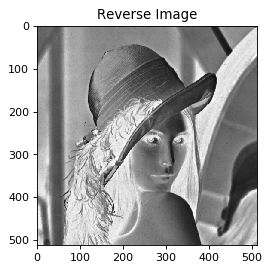

In [ ]:
img_lena = cv2.imread('lenaG.bmp',cv2.IMREAD_GRAYSCALE)
img_lenaRev = 255-img_lena
f = plt.figure(figsize=(12, 8), dpi=80)
f.add_subplot(2,2, 1)
plt.title('Reverse Image')
plt.imshow(img_lenaRev, cmap='gray')
plt.show(block=True)

## D.8
#####  Calculate the inverse of the Lena image (1/grayscale). You may need to use linear scaling to bring back the result into the interval between 0 and 255

Min Value for GrayScale: 0.0 
Max Value for GrayScale: 255.0


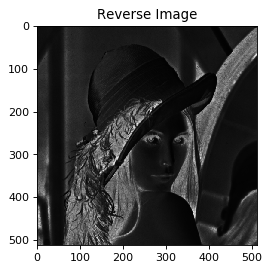

In [ ]:
img_lena = cv2.imread('lenaG.bmp',cv2.IMREAD_GRAYSCALE)
img_lenaInv = 1/img_lena
upperLimit = 255
lowerLimit = 0
imLow = np.amin(img_lenaInv)
imHigh = np.amax(img_lenaInv)
img_lenaInvLS = np.zeros((int(img_lenaInv.shape[0]),int(img_lenaInv.shape[1])))
for posX,imRow in enumerate(img_lenaInv):
    for posY,pixelValue in enumerate(imRow):
        img_lenaInvLS[posX, posY] = getPixelValueLS(pixelValue, upperLimit, lowerLimit, imLow, imHigh)

print(f"Min Value for GrayScale: {np.amin(img_lenaInvLS)} \nMax Value for GrayScale: {np.amax(img_lenaInvLS)}")

f = plt.figure(figsize=(12, 8), dpi=80)
f.add_subplot(2,2, 1)
plt.title('Reverse Image')
plt.imshow(img_lenaInvLS, cmap='gray')
plt.show(block=True)

## D.9
##### By using ‘histeq’, equalize the histogram of “NaturalView” image and compare it with the histogram stretched one. Also compare the histogram of NaturalView image after and before histogram equalization

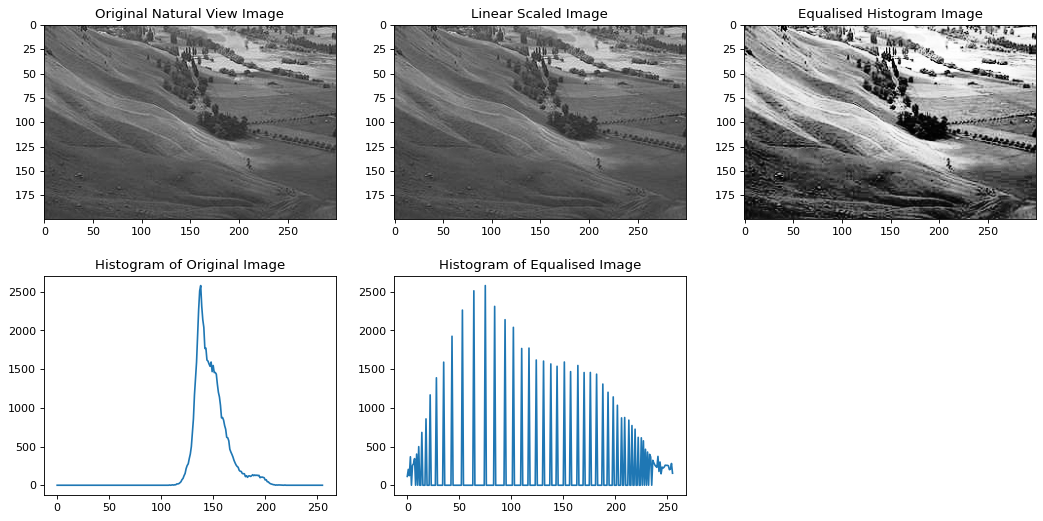

In [ ]:
img_NaturalView = cv2.imread('NaturalView.jpeg',cv2.IMREAD_GRAYSCALE)
upperLimit = 255
lowerLimit = 0
imLow = np.amin(img_NaturalView)
imHigh = np.amax(img_NaturalView)
img_NaturalViewLS = np.zeros((int(img_NaturalView.shape[0]),int(img_NaturalView.shape[1])))
for posX,imRow in enumerate(img_NaturalView):
    for posY,pixelValue in enumerate(imRow):
        img_NaturalViewLS[posX, posY] = getPixelValueLS(pixelValue, upperLimit, lowerLimit, imLow, imHigh)

img_NaturalViewEQ = cv2.equalizeHist(img_NaturalView)

f = plt.figure(figsize=(16, 8), dpi=80)
f.add_subplot(2,3, 1)
plt.title('Original Natural View Image')
plt.imshow(img_NaturalView, cmap='gray')
f.add_subplot(2,3, 2)
plt.title('Linear Scaled Image')
plt.imshow(img_NaturalViewLS, cmap='gray')
f.add_subplot(2,3, 3)
plt.title('Equalised Histogram Image')
plt.imshow(img_NaturalViewEQ, cmap='gray')
f.add_subplot(2,3, 4)
histogram, bin_edges = np.histogram(img_NaturalView, bins=256, range=(0, 256))
plt.title('Histogram of Original Image')
plt.plot(bin_edges[0:-1], histogram)
f.add_subplot(2,3, 5)
histogram, bin_edges = np.histogram(img_NaturalViewEQ, bins=256, range=(0, 256))
plt.title('Histogram of Equalised Image')
plt.plot(bin_edges[0:-1], histogram)
plt.show(block=True)